# Alexa Sentiment Analysis

In [23]:
pip install emoji

## Import Library

In [24]:
# ini adalah untuk import library
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji

nltk.download("stopwords")
nltk.download("wordnet")
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Dataset

In [25]:
df = pd.read_csv("amazon_alexa.tsv", sep="\t")

In [26]:
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [28]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## EDA

### Distribusi Rating

/tmp/ipython-input-2096540055.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="rating", palette="Blues")


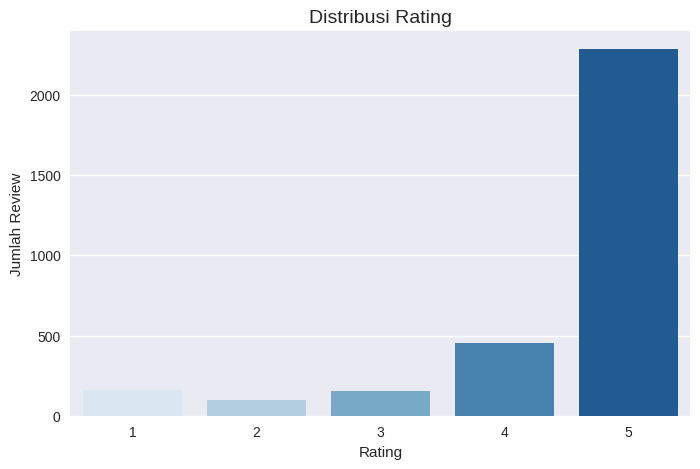

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="rating", palette="Blues")
plt.title("Distribusi Rating", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.show()

Dari plot distribusi rating, terlihat bahwa mayoritas ulasan memiliki rating tinggi, yaitu rating 5 mendominasi dengan jumlah review terbanyak, diikuti oleh rating 4. Ini menunjukkan bahwa sebagian besar pengguna memberikan feedback positif atau sangat puas dengan produk. Rating 1, 2, dan 3 memiliki jumlah ulasan yang jauh lebih sedikit, mengindikasikan bahwa ulasan negatif atau netral relatif jarang.

### Distribusi Feedback (0=Negatif, 1=Positif)

/tmp/ipython-input-1357576253.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="feedback", palette='Paired')


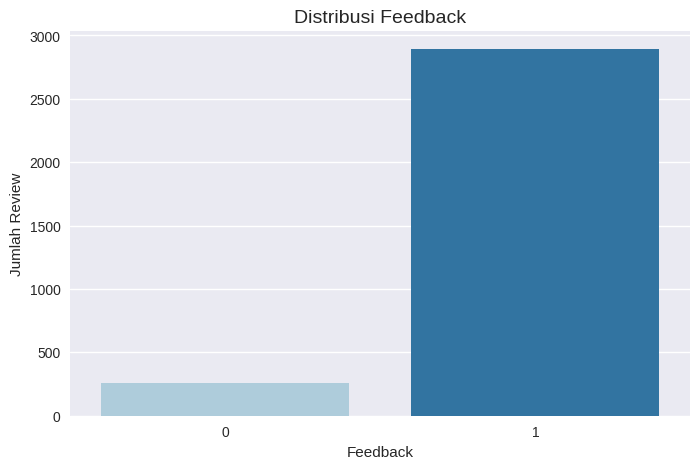

In [30]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="feedback", palette='Paired')
plt.title("Distribusi Feedback", fontsize=14)
plt.xlabel("Feedback")
plt.ylabel("Jumlah Review")
plt.show()

### Top 15 Variation

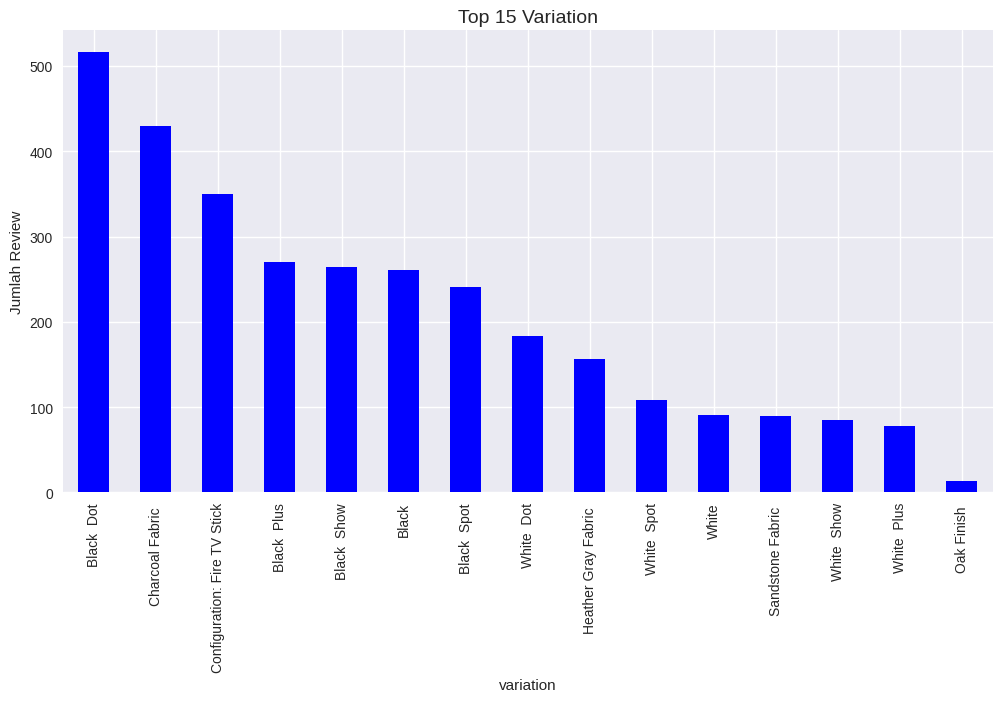

In [31]:
plt.figure(figsize=(12,6))
df["variation"].value_counts().head(15).plot(kind="bar", color="blue")
plt.title("Top 15 Variation", fontsize=14)
plt.ylabel("Jumlah Review")
plt.show()

### Feedback vs Variation (Top 10)

<Figure size 1400x600 with 0 Axes>

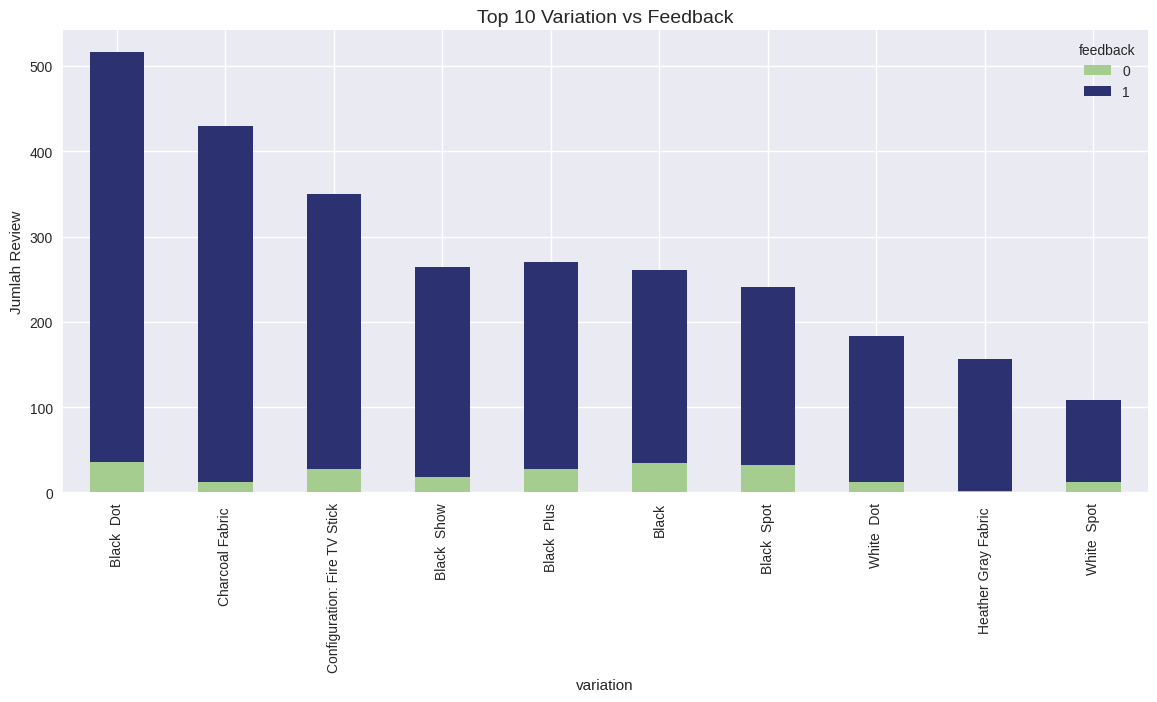

In [32]:
plt.figure(figsize=(14,6))
variation_feedback = pd.crosstab(df["variation"], df["feedback"])
variation_feedback = variation_feedback.sort_values(by=1, ascending=False).head(10)
variation_feedback.plot(kind="bar", stacked=True, figsize=(14,6), colormap="crest")
plt.title("Top 10 Variation vs Feedback", fontsize=14)
plt.ylabel("Jumlah Review")
plt.show()

### Analisis Panjang Review

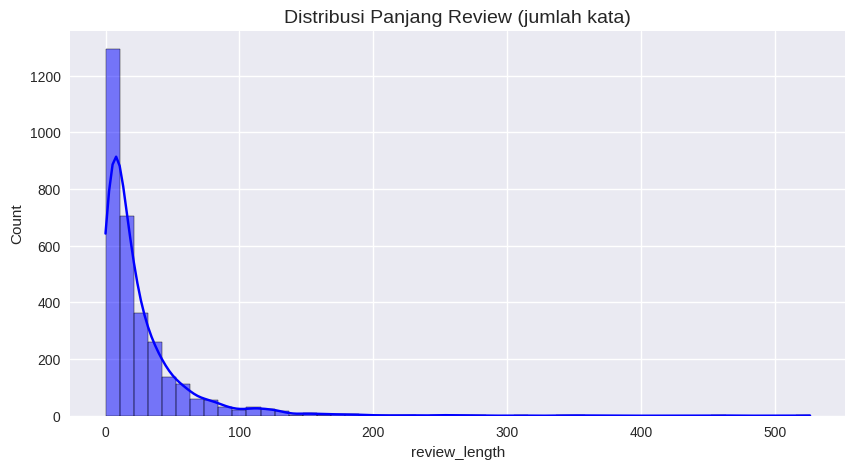

In [33]:
df["review_length"] = df["verified_reviews"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
sns.histplot(df["review_length"], bins=50, kde=True, color="blue")
plt.title("Distribusi Panjang Review (jumlah kata)", fontsize=14)
plt.show()

### WordCloud Positif & Negatif

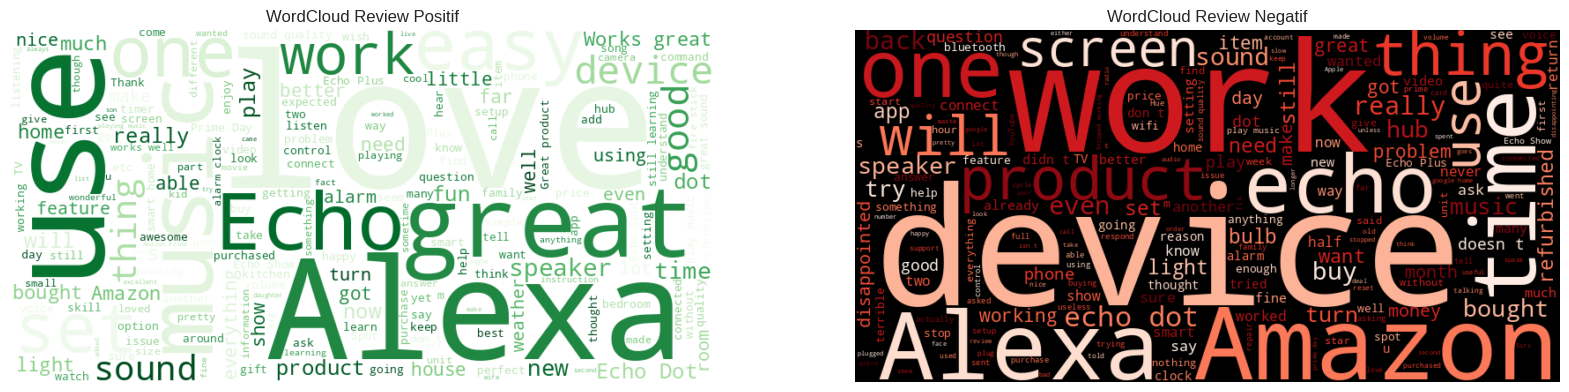

In [34]:
from wordcloud import WordCloud

positive_text = " ".join(df[df["feedback"]==1]["verified_reviews"].astype(str))
negative_text = " ".join(df[df["feedback"]==0]["verified_reviews"].astype(str))

wordcloud_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_text)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Review Positif")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Review Negatif")
plt.show()

### Top Unigram & Bigram

/tmp/ipython-input-1923465697.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=words_df, palette="crest")


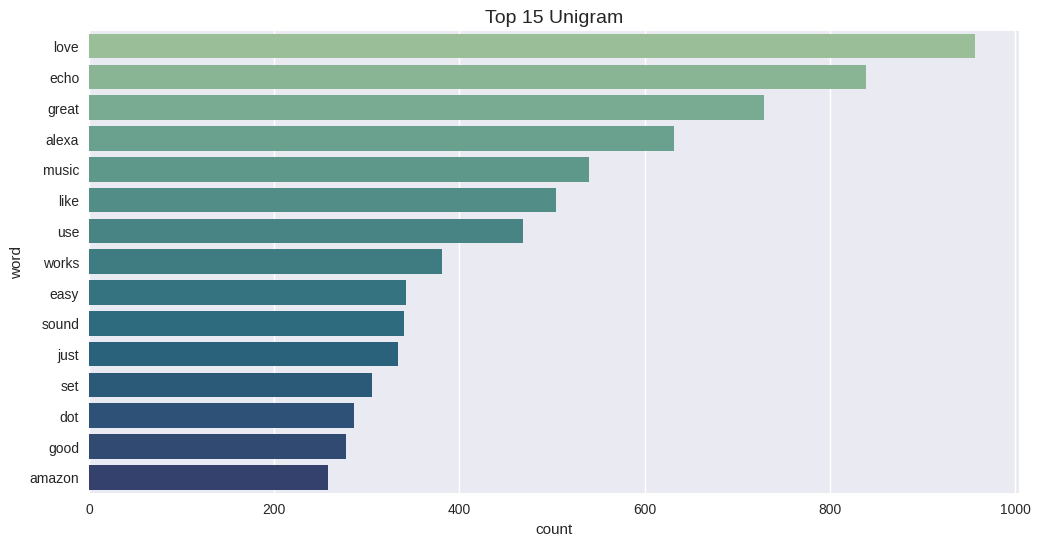

/tmp/ipython-input-1923465697.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=words_df, palette="crest")


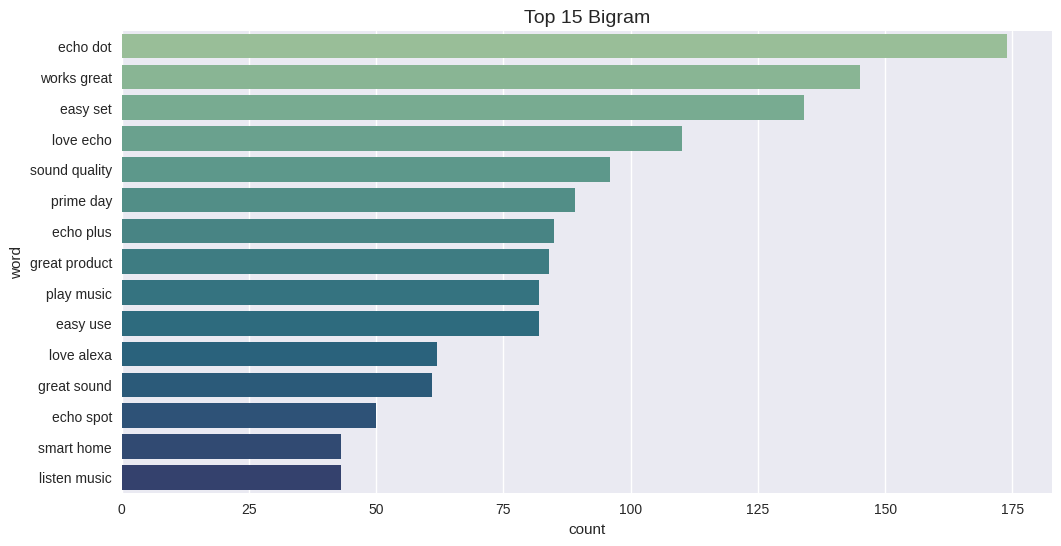

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, ngram_range=(1,1), n=15, title="Top Words"):
    # Fill missing values in 'verified_reviews' with empty string
    corpus = corpus.fillna('')
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    words_df = pd.DataFrame(words_freq, columns=["word", "count"])

    plt.figure(figsize=(12,6))
    sns.barplot(x="count", y="word", data=words_df, palette="crest")
    plt.title(title, fontsize=14)
    plt.show()

# Top unigram
plot_top_ngrams(df["verified_reviews"], ngram_range=(1,1), n=15, title="Top 15 Unigram")

# Top bigram
plot_top_ngrams(df["verified_reviews"], ngram_range=(2,2), n=15, title="Top 15 Bigram")

### Korelasi Numerik

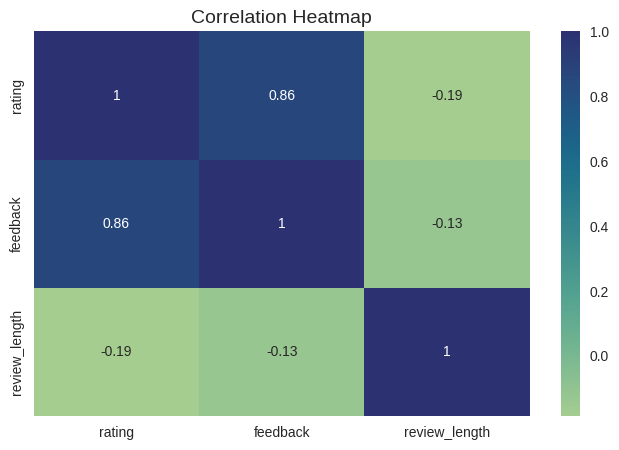

In [36]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="crest")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

###

## Text Processing

In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # lowercase dan hilangkan non ascii
    text = re.sub(r'[^\x00-\x7F]+', ' ', str(text).lower())
    # 2. menghilangkan punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # menghilangkan angka
    text = re.sub(r"\d+", " ", text)
    # menghilangkan emoji
    text = emoji.replace_emoji(text, replace=" ")
    # menghilangkan extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # tokenisasi
    words = text.split()
    # menghapus stopwords
    words = [w for w in words if w not in stop_words]
    # menghandle negasi (contoh: "not good" → "not_good")
    new_words = []
    skip = False
    for i, word in enumerate(words):
        if word == "not" and i+1 < len(words):
            new_words.append("not_" + words[i+1])
            skip = True
        elif skip:
            skip = False
            continue
        else:
            new_words.append(word)
    words = new_words

    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

In [41]:
# Drop NA pada verified_reviews
df = df.dropna(subset=["verified_reviews"]).copy()

In [42]:
# Tambahkan kolom clean_review
df["clean_review"] = df["verified_reviews"].apply(clean_text)

In [44]:
# Cek hasil
df[["verified_reviews", "clean_review"]].head()

,verified_reviews,clean_review
0,Love my Echo!,love echo
1,Loved it!,loved
2,"Sometimes while playing a game, you can answer...",sometimes playing game answer question correct...
3,I have had a lot of fun with this thing. My 4 ...,lot fun thing yr old learns dinosaur control l...
4,Music,music


## Train Test Split + FE

In [45]:
# Fitur & Target
X_text = df["clean_review"]
X_var = df["variation"]
y = df["feedback"]

In [46]:
# Train-Test Split
X_train_text, X_test_text, X_train_var, X_test_var, y_train, y_test = train_test_split(
    X_text, X_var, y, test_size=0.2, random_state=42, stratify=y
)

In [47]:
# TF-IDF untuk teks
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [48]:
# One-hot encoding untuk variation
ohe = OneHotEncoder(handle_unknown="ignore")
X_train_var_enc = ohe.fit_transform(X_train_var.to_frame())
X_test_var_enc = ohe.transform(X_test_var.to_frame())

In [49]:
# Gabungkan TF-IDF + Variation
X_train_final = hstack([X_train_tfidf, X_train_var_enc])
X_test_final = hstack([X_test_tfidf, X_test_var_enc])

print("bentuk TF-IDF Train:", X_train_tfidf.shape)
print("bentuk Variation Train:", X_train_var_enc.shape)
print("bentuk Final Train:", X_train_final.shape)

bentuk TF-IDF Train: (2519, 5000)
bentuk Variation Train: (2519, 16)
bentuk Final Train: (2519, 5016)


In [50]:
# Handling Imbalanced Data dengan SMOTE
# Terapkan SMOTE hanya pada data train
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_final, y_train)

print("Distribusi kelas sebelum SMOTE:", np.bincount(y_train))
print("Distribusi kelas sesudah SMOTE:", np.bincount(y_train_bal))


Distribusi kelas sebelum SMOTE: [ 205 2314]
Distribusi kelas sesudah SMOTE: [2314 2314]


## Modelling

### Logistic Regression

Accuracy: 0.8984126984126984

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.71      0.53        51
           1       0.97      0.92      0.94       579

    accuracy                           0.90       630
   macro avg       0.70      0.81      0.74       630
weighted avg       0.93      0.90      0.91       630



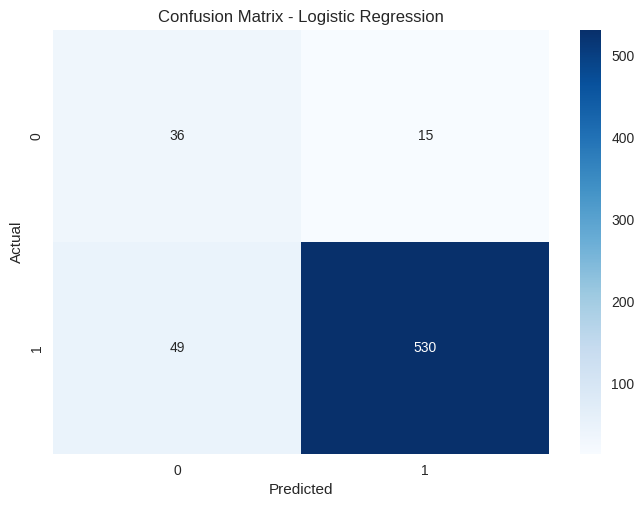

In [51]:
# Train
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_bal, y_train_bal)

# Predict
y_pred_lr = lr.predict(X_test_final)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Naive Bayes

Accuracy: 0.8809523809523809

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.78      0.52        51
           1       0.98      0.89      0.93       579

    accuracy                           0.88       630
   macro avg       0.68      0.84      0.72       630
weighted avg       0.93      0.88      0.90       630



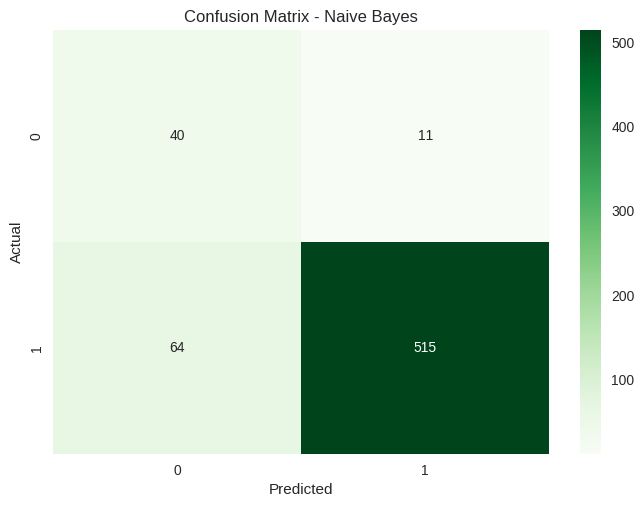

In [52]:

# Train
nb = MultinomialNB()
nb.fit(X_train_bal, y_train_bal)

# Predict
y_pred_nb = nb.predict(X_test_final)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

### Random Forest

Accuracy: 0.9285714285714286

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.37      0.46        51
           1       0.95      0.98      0.96       579

    accuracy                           0.93       630
   macro avg       0.77      0.68      0.71       630
weighted avg       0.92      0.93      0.92       630



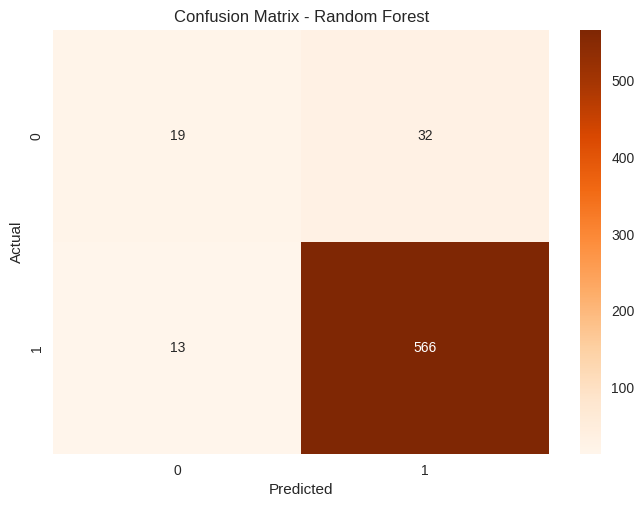

In [53]:
# Train
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predict
y_pred_rf = rf.predict(X_test_final)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:50:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9238095238095239

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.41      0.47        51
           1       0.95      0.97      0.96       579

    accuracy                           0.92       630
   macro avg       0.74      0.69      0.71       630
weighted avg       0.92      0.92      0.92       630



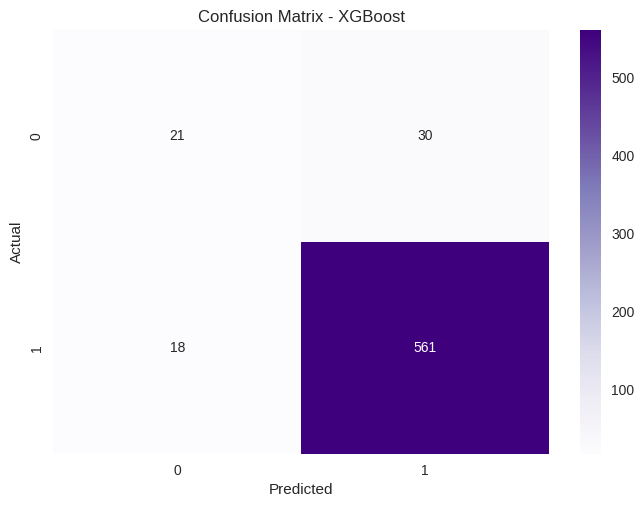

In [54]:
# Train
xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
xgb.fit(X_train_bal, y_train_bal)

# Predict
y_pred_xgb = xgb.predict(X_test_final)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

## Save Model

In [58]:
results = {
    "Model": ["Logistic Regression", "Naive Bayes", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
    ],
    "Classification Report": [
        classification_report(y_test, y_pred_lr, output_dict=True),
        classification_report(y_test, y_pred_nb, output_dict=True),
        classification_report(y_test, y_pred_rf, output_dict=True),
        classification_report(y_test, y_pred_xgb, output_dict=True),
    ],
}

In [59]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("\nModel Performance Comparison:")
print(results_df[["Model", "Accuracy"]])



Model Performance Comparison:
                 Model  Accuracy
0  Logistic Regression  0.898413
1          Naive Bayes  0.880952
2        Random Forest  0.928571
3              XGBoost  0.923810


In [60]:
# Save & Load Model Terbaik

# Pilih model dengan akurasi tertinggi
best_model_name = results_df.sort_values(by="Accuracy", ascending=False).iloc[0]["Model"]
print(f"\nModel terbaik berdasarkan akurasi: {best_model_name}")

# Map model name to the actual model object
model_map = {
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "Random Forest": rf,
    "XGBoost": xgb,
}
best_model = model_map[best_model_name]

# Simpan model
joblib.dump(best_model, "best_model.pkl")
print("✅ Model berhasil disimpan: best_model.pkl")

# Simpan TF-IDF vectorizer & OneHotEncoder
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(ohe, "onehot_encoder.pkl")
print("✅ Vectorizer & Encoder disimpan")


Model terbaik berdasarkan akurasi: Random Forest
✅ Model berhasil disimpan: best_model.pkl
✅ Vectorizer & Encoder disimpan
